<br><br><br><br>
<h1>01. Exploring Marginal Distributions of stock data returns</h1>

<p>Applying heteroskedastic time series models to asset data and retrieving the marginal distribution.</p>

<br><br><br><br>
<h2>0. Document setup</h2>

In [106]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox




# Add project root so we can import from src/
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

<br><br><br><br>
<h2>1. Data preparation</h2>

In [2]:
from src.data_handlers.yfinance_data_loader import load_prices

prices_appl = load_prices("AAPL", "2015-01-01", "2024-01-01")

prices_ge = load_prices("GE", "2015-01-01", "2024-01-01")


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


[load_prices] Cache file is invalid, redownloading: AAPL_2015-01-01_2024-01-01.csv


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


[load_prices] Cache file is invalid, redownloading: GE_2015-01-01_2024-01-01.csv


In [3]:
prices_ge.head()

,Close,High,Low,Open,Volume
2015-01-02,102.697220,104.336443,101.918592,103.844673,8538620
2015-01-05,100.812119,102.492319,100.484277,102.492319,8770735
2015-01-06,98.640160,100.689185,98.066436,100.238399,13304295
2015-01-07,98.681129,99.951527,98.271320,99.213876,9106535
2015-01-08,99.869560,99.910537,98.886028,99.664656,9019294


In [4]:

prices_appl.head()

,Close,High,Low,Open,Volume
2015-01-02,24.237551,24.705320,23.798600,24.694235,212818400
2015-01-05,23.554745,24.086805,23.368524,24.006996,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887280,23.987040,23.654503,23.765348,160423600
2015-01-08,24.805080,24.862721,24.097883,24.215381,237458000


<br><br><br><br>
<h3>Price plots</h3>

<Axes: title={'center': 'GE price'}>

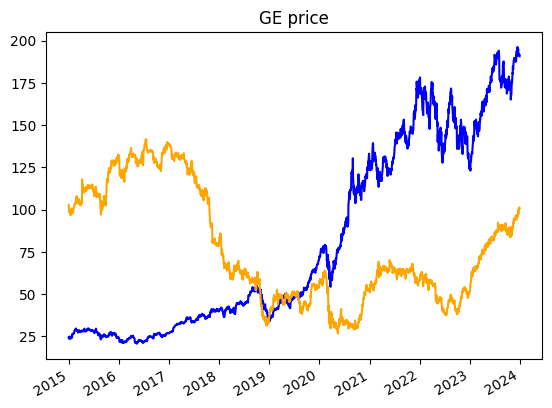

In [29]:
prices_appl["Close"].plot(title="AAPL price", color="b")
prices_ge["Close"].plot(title="GE price", color="orange")

<br><br><br><br>
<h3>Extracting log returns</h3>

In [7]:
returns_aapl = np.log(prices_appl["Close"]).diff().dropna()
returns_ge   = np.log(prices_ge["Close"]).diff().dropna()

<Axes: title={'center': 'AAPL log returns'}>

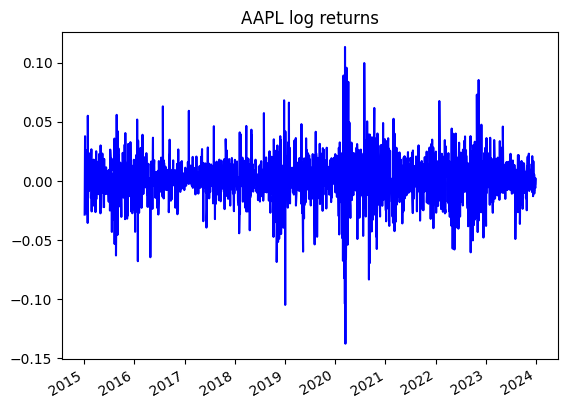

In [30]:
returns_aapl.plot(title="AAPL log returns", color="b")


<Axes: title={'center': 'GE log returns'}>

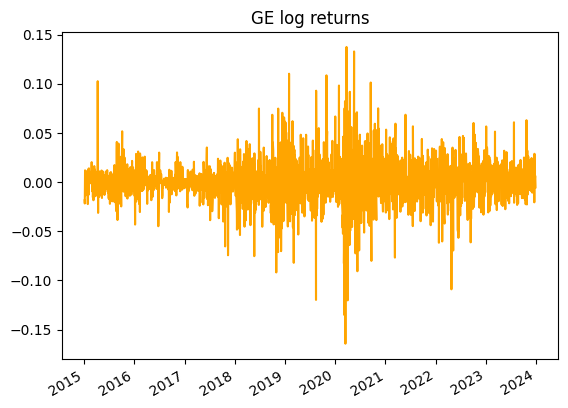

In [27]:
returns_ge.plot(title="GE log returns", color="orange")

<br><br><br><br>
<h2>2. Analyzing distribution of returns</h2>

<br><br><br><br>
<h3>Distribution of returns</h3>

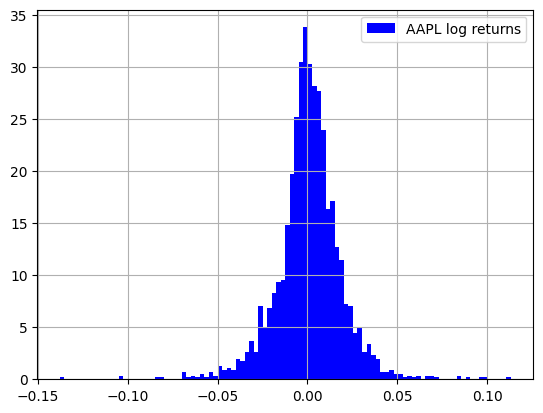

In [39]:
returns_aapl.hist(bins=100, density=True, color='b', label='AAPL log returns')
plt.legend()

<br><br><br><br>
<p>Fitting distributions to APPL log-returns</p>

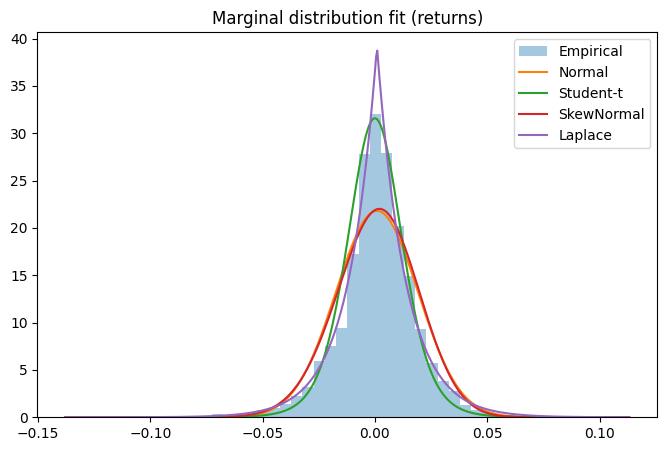

,Distribution,KS statistic,p-value
3,Laplace,0.026780,7.646080e-02
1,Student-t,0.043607,3.543307e-04
2,SkewNormal,0.073550,4.312240e-11
0,Normal,0.078794,1.145763e-12


In [43]:

# Choose returns (assumed already computed)
x = returns_aapl.values
x = x[np.isfinite(x)]

# Candidate distributions
distributions = {
    "Normal": stats.norm,
    "Student-t": stats.t,
    "SkewNormal": stats.skewnorm,
    "Laplace": stats.laplace
}

results = []

# Grid-search df for Student-t (optional, otherwise MLE handles it)
t_df_grid = [3, 5, 8, 12, 20]

# Histogram base
plt.figure(figsize=(8, 5))
plt.hist(x, bins=50, density=True, alpha=0.4, label="Empirical")

xx = np.linspace(x.min(), x.max(), 500)

for name, dist in distributions.items():
    if name == "Student-t":
        best = None

        for df in t_df_grid:
            params = (df,) + dist.fit(x, floc=0)[1:]
            ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

            if best is None or ks_stat < best["ks"]:
                best = {"params": params, "ks": ks_stat, "pval": pval}

        params = best["params"]
        ks_stat = best["ks"]
        pval = best["pval"]

    else:
        params = dist.fit(x)
        ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

    results.append({
        "Distribution": name,
        "KS statistic": ks_stat,
        "p-value": pval
    })

    pdf = dist.pdf(xx, *params)
    plt.plot(xx, pdf, label=f"{name}")

plt.title("Marginal distribution fit (returns)")
plt.legend()
plt.show()

# Display results
results_df = pd.DataFrame(results).sort_values("KS statistic")
results_df

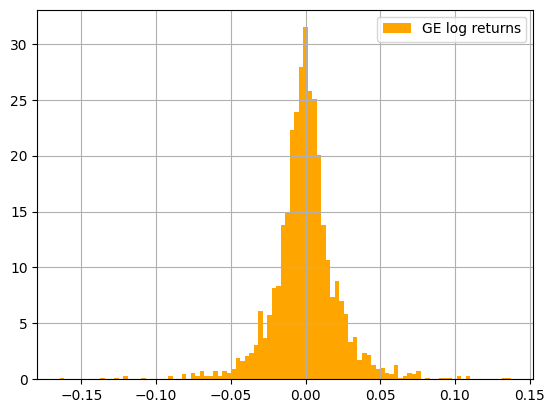

In [36]:
returns_ge.hist(bins=100, density=True, color='orange', label='GE log returns')
plt.legend()

<br><br><br><br>
<p>Fitting distributions to GE log-returns</p>

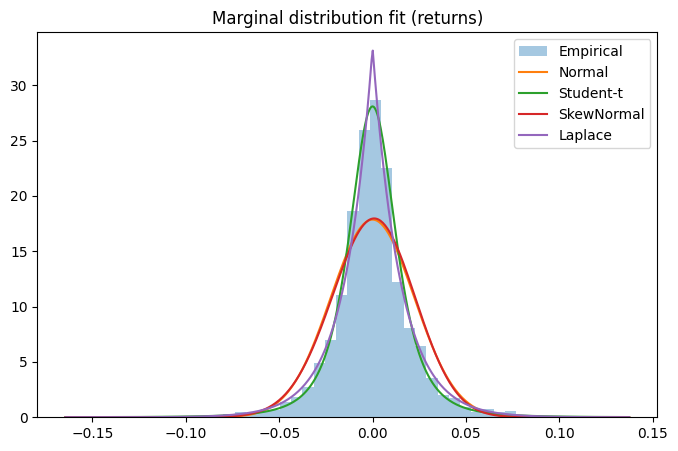

,Distribution,KS statistic,p-value
3,Laplace,0.020225,3.086964e-01
1,Student-t,0.021033,2.656730e-01
0,Normal,0.091438,6.473858e-17
2,SkewNormal,0.093171,1.511643e-17


In [44]:

# Choose returns (assumed already computed)
x = returns_ge.values
x = x[np.isfinite(x)]

# Candidate distributions
distributions = {
    "Normal": stats.norm,
    "Student-t": stats.t,
    "SkewNormal": stats.skewnorm,
    "Laplace": stats.laplace
}

results = []

# Grid-search df for Student-t (optional, otherwise MLE handles it)
t_df_grid = [3, 5, 8, 12, 20]

# Histogram base
plt.figure(figsize=(8, 5))
plt.hist(x, bins=50, density=True, alpha=0.4, label="Empirical")

xx = np.linspace(x.min(), x.max(), 500)

for name, dist in distributions.items():
    if name == "Student-t":
        best = None

        for df in t_df_grid:
            params = (df,) + dist.fit(x, floc=0)[1:]
            ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

            if best is None or ks_stat < best["ks"]:
                best = {"params": params, "ks": ks_stat, "pval": pval}

        params = best["params"]
        ks_stat = best["ks"]
        pval = best["pval"]

    else:
        params = dist.fit(x)
        ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

    results.append({
        "Distribution": name,
        "KS statistic": ks_stat,
        "p-value": pval
    })

    pdf = dist.pdf(xx, *params)
    plt.plot(xx, pdf, label=f"{name}")

plt.title("Marginal distribution fit (returns)")
plt.legend()
plt.show()

# Display results
results_df = pd.DataFrame(results).sort_values("KS statistic")
results_df

<br><br><br><br>
<h3>Correlation of returns</h3>

In [42]:
R = pd.concat([returns_aapl, returns_ge], axis=1).dropna()
R.columns = ["AAPL", "GE"]

R.corr()

,AAPL,GE
AAPL,1.000000,0.349112
GE,0.349112,1.000000


<br><br><br><br>
<h3>ACF and Absolute ACF of log returns</h3>

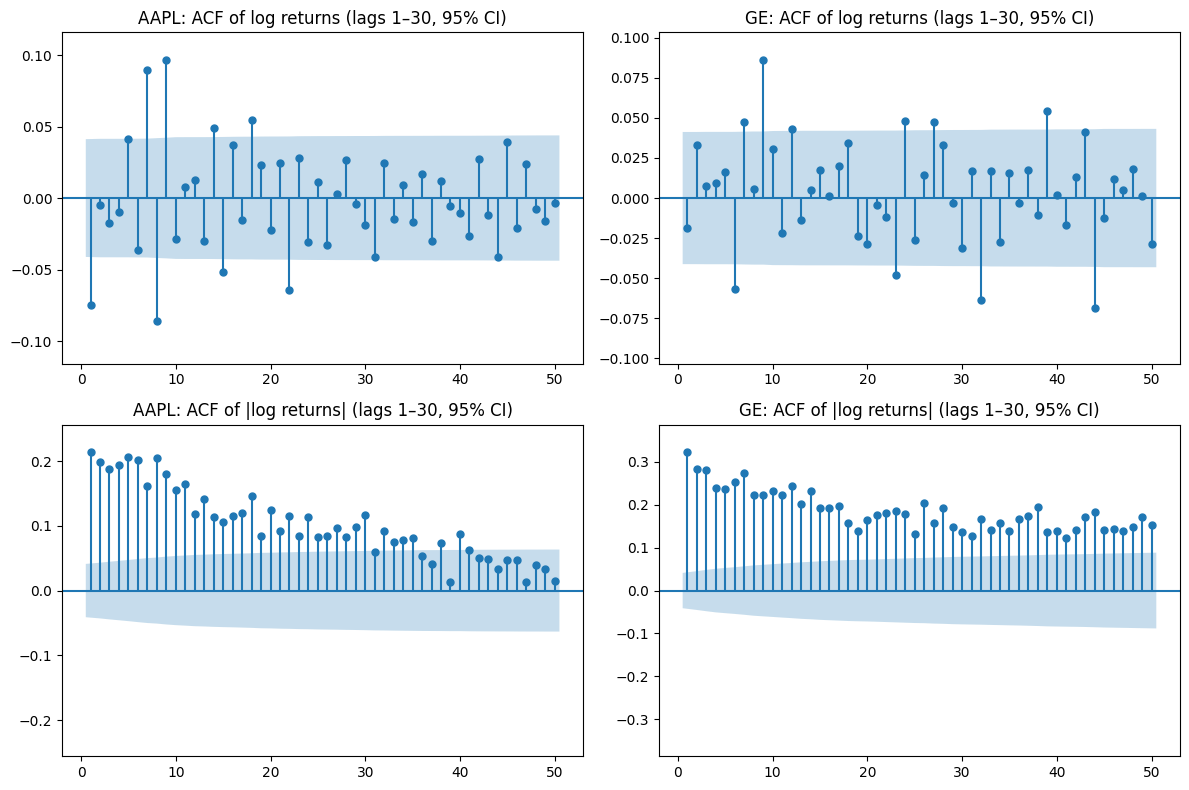

In [52]:
lags = 50
conf_level = 0.95

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

def plot_acf_scaled(series, ax, title):
    plot_acf(
        series,
        lags=lags,
        ax=ax,
        zero=False,
        alpha=1 - conf_level
    )

    # Get current y-data limits from plotted lines
    lines = ax.lines
    y_vals = np.concatenate([line.get_ydata() for line in lines if len(line.get_ydata()) > 0])

    # Add padding
    ymax = np.max(np.abs(y_vals))
    ax.set_ylim(-1.2 * ymax, 1.2 * ymax)

    ax.set_title(title)


# --- AAPL ---
plot_acf_scaled(
    returns_aapl,
    axes[0, 0],
    "AAPL: ACF of log returns (lags 1–30, 95% CI)"
)

plot_acf_scaled(
    abs(returns_aapl),
    axes[1, 0],
    "AAPL: ACF of |log returns| (lags 1–30, 95% CI)"
)

# --- GE ---
plot_acf_scaled(
    returns_ge,
    axes[0, 1],
    "GE: ACF of log returns (lags 1–30, 95% CI)"
)

plot_acf_scaled(
    abs(returns_ge),
    axes[1, 1],
    "GE: ACF of |log returns| (lags 1–30, 95% CI)"
)

plt.tight_layout()
plt.show()

<br><br><br><br>
<h2>3. Fitting marginal distributions</h2>

<br><br><br><br>
<h2>3. Fitting models to return time series</h2>

<br><br><br><br>
<h3>Fitting mean functions</h3>

<br><br><br><br>
APPL returns mean

In [54]:

x = returns_aapl.values
x = x[np.isfinite(x)]

n = len(x)
mu_hat = x.mean()
sigma_hat = x.std(ddof=1)
se = sigma_hat / np.sqrt(n)
t_stat = mu_hat / se
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))

results = pd.DataFrame(
    {
        "Estimate": [mu_hat],
        "Std. Error": [se],
        "t-stat": [t_stat],
        "p-value": [p_value],
        "N": [n],
    },
    index=["Mean return"]
)

results

,Estimate,Std. Error,t-stat,p-value,N
Mean return,0.000912,0.000385,2.369759,0.017883,2263


<br><br><br><br>
GE returns mean

In [55]:

x = returns_ge.values
x = x[np.isfinite(x)]

n = len(x)
mu_hat = x.mean()
sigma_hat = x.std(ddof=1)
se = sigma_hat / np.sqrt(n)
t_stat = mu_hat / se
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))

results = pd.DataFrame(
    {
        "Estimate": [mu_hat],
        "Std. Error": [se],
        "t-stat": [t_stat],
        "p-value": [p_value],
        "N": [n],
    },
    index=["Mean return"]
)

results

,Estimate,Std. Error,t-stat,p-value,N
Mean return,-0.000009,0.00047,-0.01816,0.985513,2263


<br><br><br><br><br>
<b>ASSUMPTION/CONCLUSION:</b> I will assume mean is zero for both APPL and GE

<br><br><br><br>
<h3>Fitting heteroskedastic volatility models</h3>

Function for grid search of ARCH/GARCH models and Normal vs. Student-t distribution

In [64]:
def fit_vol_models(returns, asset_name):
    rows = []
    fitted_models = {}

    model_grid = [
        {"vol": "ARCH", "p": 1, "q": 0},
        {"vol": "ARCH", "p": 2, "q": 0},
        {"vol": "ARCH", "p": 3, "q": 0},
        {"vol": "GARCH", "p": 1, "q": 1},
        {"vol": "GARCH", "p": 1, "q": 2},
        {"vol": "GARCH", "p": 2, "q": 1},
    ]

    dists = ["normal", "t"]

    for spec in model_grid:
        for dist in dists:
            try:
                am = arch_model(
                    returns,
                    mean="Constant",
                    vol=spec["vol"],
                    p=spec["p"],
                    q=spec["q"],
                    dist=dist,
                )
                res = am.fit(disp="off")

                z = res.std_resid.dropna()

                lb_z = acorr_ljungbox(z, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
                lb_z2 = acorr_ljungbox(z**2, lags=[10], return_df=True)["lb_pvalue"].iloc[0]

                model_name = f"{spec['vol']}({spec['p']},{spec['q']})"

                rows.append({
                    "Asset": asset_name,
                    "Model": model_name,
                    "Dist": dist,
                    "AIC": res.aic,
                    "LB(z) pval": lb_z,
                    "LB(z^2) pval": lb_z2,
                    "alpha+beta": (
                        res.params.get("alpha[1]", 0) + res.params.get("beta[1]", 0)
                        if spec["vol"] == "GARCH" else None
                    ),
                })

                # ⭐ store fitted model
                fitted_models[(model_name, dist)] = res

            except Exception:
                continue

    results_df = pd.DataFrame(rows).sort_values("AIC")
    return results_df, fitted_models


<br><br><br><br>
Rescaling returns dataframes for better parameter estimation

In [67]:
returns_aapl_scaled = 100 * returns_aapl
returns_ge_scaled   = 100 * returns_ge

<br><br><br><br>
APPL volatility model grid search

In [73]:
results_aapl, models_appl = fit_vol_models(returns_aapl_scaled, "AAPL")
results_aapl

,Asset,Model,Dist,AIC,LB(z) pval,LB(z^2) pval,alpha+beta
7,AAPL,"GARCH(1,1)",t,8497.001422,0.116330,9.738977e-01,0.983071
9,AAPL,"GARCH(1,2)",t,8498.299824,0.116724,9.748873e-01,0.754416
11,AAPL,"GARCH(2,1)",t,8499.001422,0.116327,9.739003e-01,0.983073
5,AAPL,"ARCH(3,0)",t,8601.345938,0.081702,1.251603e-02,NaN
3,AAPL,"ARCH(2,0)",t,8633.416731,0.019730,1.252513e-06,NaN
6,AAPL,"GARCH(1,1)",normal,8676.709949,0.127163,9.832052e-01,0.957741
10,AAPL,"GARCH(2,1)",normal,8678.473463,0.126867,9.807713e-01,0.941262
8,AAPL,"GARCH(1,2)",normal,8678.709949,0.127163,9.832050e-01,0.957741
1,AAPL,"ARCH(1,0)",t,8682.045427,0.003530,2.988241e-38,NaN
4,AAPL,"ARCH(3,0)",normal,8836.311000,0.048916,9.291004e-04,NaN


<br><br><br><br>
GE volatility model grid search

In [74]:
results_ge, models_ge = fit_vol_models(returns_ge_scaled, "GE")
results_ge

,Asset,Model,Dist,AIC,LB(z) pval,LB(z^2) pval,alpha+beta
9,GE,"GARCH(1,2)",t,9020.383231,0.702354,7.716676e-01,0.429247
7,GE,"GARCH(1,1)",t,9024.900353,0.787241,5.225391e-01,1.000000
11,GE,"GARCH(2,1)",t,9026.900354,0.787233,5.225405e-01,1.000000
5,GE,"ARCH(3,0)",t,9181.692898,0.291975,1.541802e-01,NaN
3,GE,"ARCH(2,0)",t,9254.909187,0.134849,3.147569e-06,NaN
8,GE,"GARCH(1,2)",normal,9307.448261,0.564850,7.886451e-01,0.403797
1,GE,"ARCH(1,0)",t,9312.607727,0.005298,3.333023e-15,NaN
6,GE,"GARCH(1,1)",normal,9319.184029,0.646146,5.560989e-01,0.996535
10,GE,"GARCH(2,1)",normal,9321.184029,0.646142,5.561035e-01,0.996535
4,GE,"ARCH(3,0)",normal,9530.727678,0.211020,1.307031e-01,NaN


<br><br><br><br><br>
<b>ASSUMPTION/CONCLUSION:</b> <br>
APPL vol. model: GARCH(1,1), student-t innovations<br>
GE vol. model: GARCH(1,2), student-t innovations<br>

<br><br><br><br>
Picking best volatility model for each stock

In [ ]:
best_specs = {
    "AAPL": results_aapl.iloc[0],
    "GE": results_ge.iloc[0],
}

best_res = {
    "AAPL": models_appl[
        (best_specs["AAPL"]["Model"], best_specs["AAPL"]["Dist"])
    ],
    "GE": models_ge[
        (best_specs["GE"]["Model"], best_specs["GE"]["Dist"])
    ],
}


<br><br><br><br>
<h3>Extracting residuals and volatility time series from volatility models</h3>

<br><br><br><br>
Function for volatility and residual extraction

In [85]:
def extract_vol_and_residuals(returns, res, scale=100.0):
    """
    returns: unscaled returns Series (log returns)
    res: ARCHModelResult fitted on scaled returns (e.g. 100*returns)
    scale: scaling factor used in fitting
    """
    df = pd.DataFrame(index=returns.index)

    df["return"] = returns
    df["sigma"] = res.conditional_volatility / scale
    df["resid"] = res.resid / scale
    df["z"] = res.std_resid

    # PIT using the fitted innovation distribution
    dist = res.model.distribution
    dist_params = res.params[dist.parameter_names()].to_numpy()
    df["u"] = dist.cdf(df["z"].to_numpy(), dist_params)

    return df.dropna()

<br><br><br><br>
Extracting residuals and volatility

In [86]:
aapl_garch = extract_vol_and_residuals(returns_aapl, best_res["AAPL"])
ge_garch   = extract_vol_and_residuals(returns_ge, best_res["GE"])

<br><br><br><br>
Function for plotting residuals and volatility

In [96]:
def plot_garch_parts(df, mu=0.0, title_prefix=""):
    """
    df must contain:
        - return : original returns
        - sigma  : conditional volatility
        - z      : standardized residuals
    mu: mean return (in original units)
    """

    upper = mu + 2 * df["sigma"]
    lower = mu - 2 * df["sigma"]

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    # 1️⃣ Returns with volatility bands
    df["return"].plot(ax=axes[0], label="r_t", alpha=0.8)
    upper.plot(ax=axes[0], linestyle="--", color="red", alpha=0.8, label="μ ± 2σ_t")
    lower.plot(ax=axes[0], linestyle="--", color="red", alpha=0.8)
    axes[0].set_title(f"{title_prefix} Returns with GARCH volatility bands")
    axes[0].legend()

    # 2️⃣ Conditional volatility
    df["sigma"].plot(ax=axes[1])
    axes[1].set_title(f"{title_prefix} Conditional volatility σ_t")

    # 3️⃣ Standardized residuals (this is the key!)
    df["z"].plot(ax=axes[2])
    axes[2].set_title(f"{title_prefix} Standardized residuals z_t = ε_t / σ_t")

    plt.tight_layout()
    plt.show()


<br><br><br><br>
APPL residuals and volatility

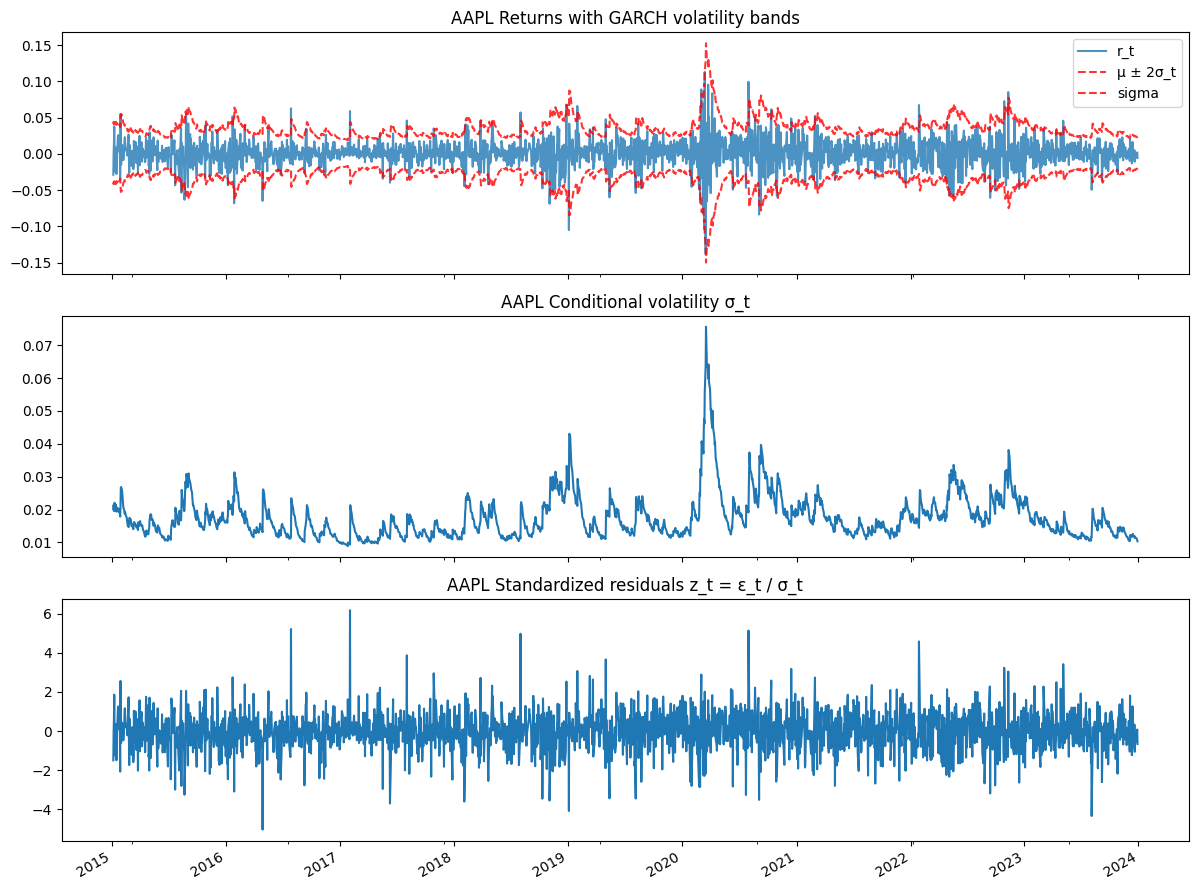

In [97]:
mu_aapl = best_res["AAPL"].params.get("mu", 0.0) / 100.0

plot_garch_parts(
    aapl_garch,
    mu=mu_aapl,
    title_prefix="AAPL"
)


<br><br><br><br>
GE residuals and volatility

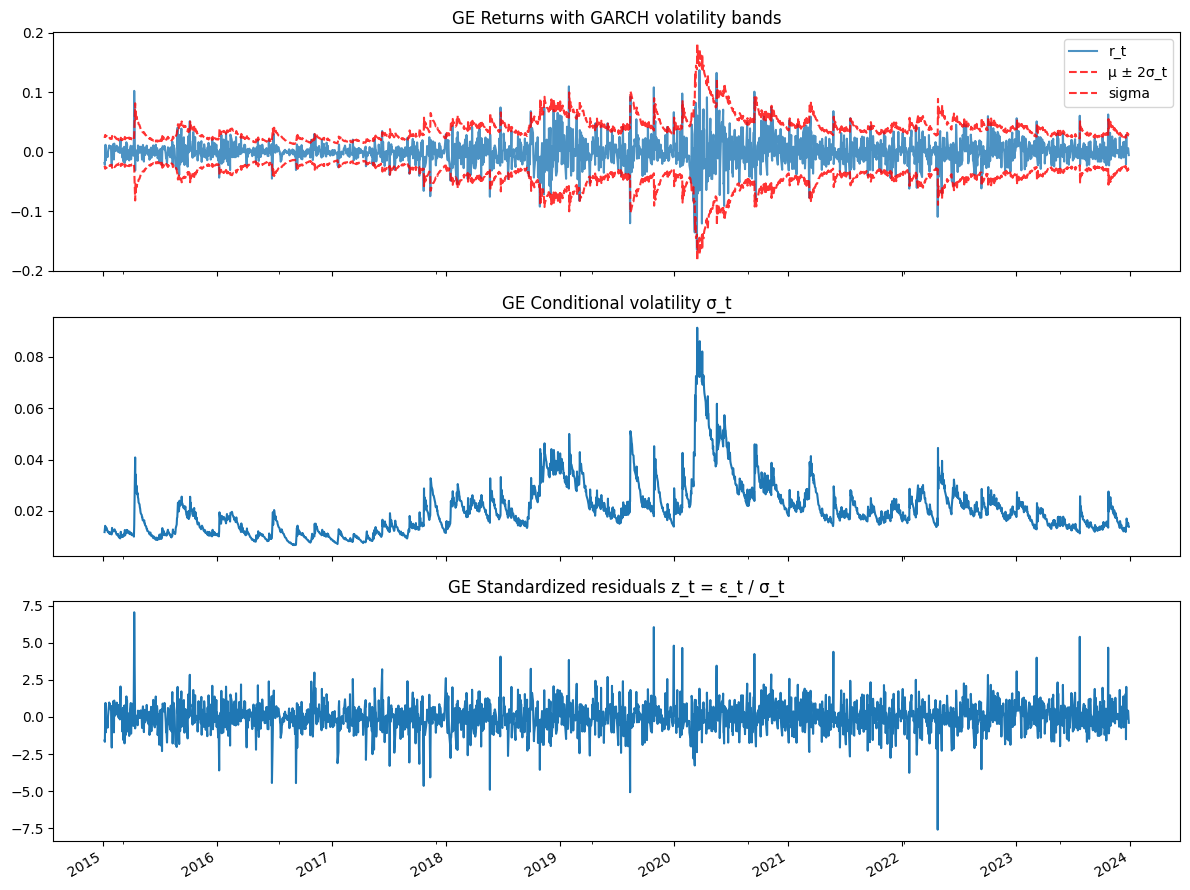

In [98]:
mu_ge = best_res["GE"].params.get("mu", 0.0) / 100.0

plot_garch_parts(
    ge_garch,
    mu=mu_ge,
    title_prefix="GE"
)



<br><br><br><br>
<h3>Checking standardized residuals for i.i.d. noise</h3>

<br><br><br><br>
Function for checking i.i.d. nature and PDF of standardized residuals

In [ ]:

def innovation_diagnostics(df, res, name="", lags=35, conf_level=0.95, bins=60):
    z = df["z"].dropna().to_numpy()

    # Ljung–Box tests
    lb_z  = acorr_ljungbox(z, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]
    lb_abs = acorr_ljungbox(np.abs(z), lags=[lags], return_df=True)["lb_pvalue"].iloc[0]
    lb_z2 = acorr_ljungbox(z**2, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]

    # Get the fitted innovation distribution info from arch
    dist = res.model.distribution
    dist_name = getattr(dist, "name", dist.__class__.__name__)

    # Params for distribution (e.g., nu for Student-t)
    param_names = dist.parameter_names()
    dist_params = res.params[param_names].to_numpy() if len(param_names) > 0 else np.array([])

    # CDF function (arch provides this)
    cdf_func = lambda x: dist.cdf(np.asarray(x), dist_params)

    # KS test vs fitted CDF (p-value approximate due to estimated params)
    ks_stat, ks_pval = stats.kstest(z, cdf_func)

    # Plot ACF(z), ACF(|z|), histogram + fitted PDF (scipy for normal/t)
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    plot_acf(z, lags=lags, zero=False, alpha=1-conf_level, ax=axes[0])
    axes[0].set_title(f"{name} ACF of z_t (lags 1–{lags}, {int(conf_level*100)}% CI)")

    plot_acf(np.abs(z), lags=lags, zero=False, alpha=1-conf_level, ax=axes[1])
    axes[1].set_title(f"{name} ACF of |z_t| (lags 1–{lags}, {int(conf_level*100)}% CI)")

    # Histogram + pdf overlay
    xx = np.linspace(np.percentile(z, 0.5), np.percentile(z, 99.5), 500)
    axes[2].hist(z, bins=bins, density=True, alpha=0.4, label="z_t (empirical)")

    # Try to overlay a PDF using SciPy for common distributions
    overlay_done = False
    if "student" in dist_name.lower() or dist_name.lower() in ["t", "studentst"]:
        # arch Student-t uses df parameter nu
        nu = float(dist_params[0]) if dist_params.size > 0 else None
        if nu is not None:
            axes[2].plot(xx, stats.t.pdf(xx, df=nu), label=f"Student-t pdf (nu={nu:.2f})")
            overlay_done = True

    elif "normal" in dist_name.lower() or dist_name.lower() in ["gaussian", "normal"]:
        axes[2].plot(xx, stats.norm.pdf(xx, loc=0, scale=1), label="Normal pdf (0,1)")
        overlay_done = True

    if not overlay_done:
        axes[2].text(
            0.02, 0.95,
            f"No SciPy pdf overlay for dist='{dist_name}'",
            transform=axes[2].transAxes,
            va="top"
        )

    axes[2].set_title(f"{name} innovation fit\nKS={ks_stat:.4f}, p={ks_pval:.2e}")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"=== {name} innovation diagnostics ===")
    print(f"Ljung–Box p-value on z_t   (want high): {lb_z:.4f}")
    print(f"Ljung–Box p-value on |z_t| (want high): {lb_abs:.4f}")
    print(f"Ljung–Box p-value on z_t^2 (want high): {lb_z2:.4f}")
    print(f"KS vs fitted {dist_name}: statistic={ks_stat:.4f}, p={ks_pval:.2e}")
    print("\nRules of thumb:")
    print("- Ljung–Box: p > 0.05 (or 0.10) ⇒ no evidence of leftover autocorrelation.")
    print("- KS: p > 0.05 would be 'not rejected', BUT p-values are approximate when params are estimated.")
    print("  Use KS mainly to compare distributions + rely on the overlay and Ljung–Box on z^2.\n")

    return {
        "lb_z_pval": lb_z,
        "lb_absz_pval": lb_abs,
        "lb_z2_pval": lb_z2,
        "ks_stat": ks_stat,
        "ks_pval": ks_pval,
        "dist_name": dist_name,
        "dist_params": dist_params
    }


<br><br><br><br>
Checking AAPL standardized residuals

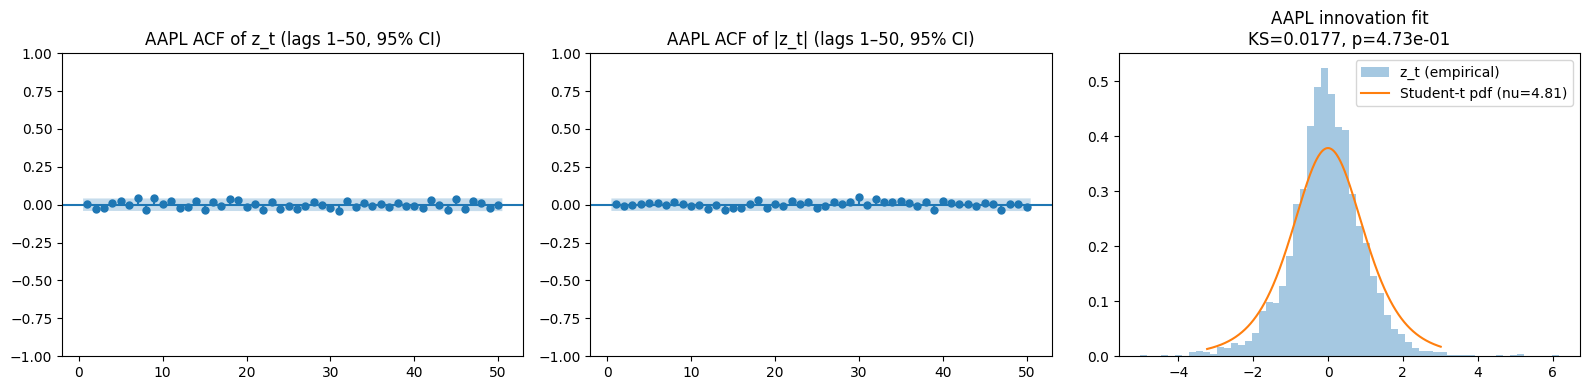

=== AAPL innovation diagnostics ===
Ljung–Box p-value on z_t   (want high): 0.1772
Ljung–Box p-value on |z_t| (want high): 0.9083
Ljung–Box p-value on z_t^2 (want high): 0.9972
KS vs fitted Standardized Student's t: statistic=0.0177, p=4.73e-01

Rules of thumb:
- Ljung–Box: p > 0.05 (or 0.10) ⇒ no evidence of leftover autocorrelation.
- KS: p > 0.05 would be 'not rejected', BUT p-values are approximate when params are estimated.
  Use KS mainly to compare distributions + rely on the overlay and Ljung–Box on z^2.



In [110]:
diag_aapl = innovation_diagnostics(aapl_garch, best_res["AAPL"], name="AAPL", lags=50)

<br><br><br><br>
Checking GE standardized residuals

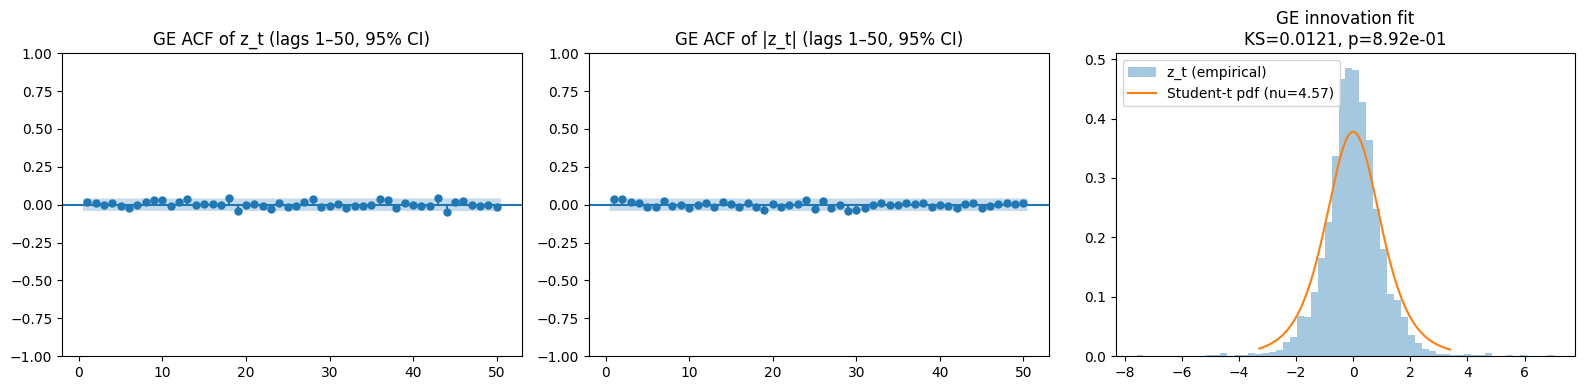

=== GE innovation diagnostics ===
Ljung–Box p-value on z_t   (want high): 0.5004
Ljung–Box p-value on |z_t| (want high): 0.9380
Ljung–Box p-value on z_t^2 (want high): 0.9989
KS vs fitted Standardized Student's t: statistic=0.0121, p=8.92e-01

Rules of thumb:
- Ljung–Box: p > 0.05 (or 0.10) ⇒ no evidence of leftover autocorrelation.
- KS: p > 0.05 would be 'not rejected', BUT p-values are approximate when params are estimated.
  Use KS mainly to compare distributions + rely on the overlay and Ljung–Box on z^2.



In [109]:
a = innovation_diagnostics(ge_garch,   best_res["GE"],   name="GE",   lags=50)

<br><br><br><br>
<h2>4. Presenting final marginals and conclusions for marginal distributions</h2>